# Normalizing flows - Linear regression (PyTorch)

In [1]:
__author__ = 'carlos.diaz@astro.su.se'
!which python

/usr/local/bin/python


In [2]:
# We need to install the libraries to use the flows (nflows), 
# do some plots (corner) and to run an MCMC (emcee)
try:
    import emcee
    import corner
    import nflows
except:
    !pip install emcee
    !pip install corner
    !pip install nflows
    import emcee
    import corner
    import nflows

     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 45 kB 2.1 MB/s 
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53671 sha256=b29fa3acd72b78de37c0408034793be66213acb3a21ce76f415f40ffcd0ee4c1
  Stored in directory: /root/.cache/pip/wheels/c0/b6/52/0092eedabce8f7faa35b92522393fbdc1ec5ede99b0ec820d5
Successfully built nflows


In [3]:
# We also import few more libraries to plots,
# time measurements, and the creation of the normalizing flow

import numpy as np
import matplotlib.pyplot as plt

import torch
import time
import torch.utils.data
from torch.nn import functional as F
from nflows.flows.base import Flow
from nflows.transforms.base import CompositeTransform
from nflows import distributions, flows, transforms, utils
from nflows.nn import nets

# By default it can run on CPU, you do not need a GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
print('Pytorch:',torch.__version__)
if torch.cuda.is_available() is True:
    print(torch.cuda.get_device_name(0))

# Fixing seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

Device: cpu
Pytorch: 1.9.0+cu111


In [4]:
# Dictionary to save important information
class dotdict(dict): 
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__

In [5]:
# Configuration for the training process
args = dotdict()
args.learning_rate = 1e-4 
args.num_epochs = 12
args.log_interval = 2
args.batch_size = 100

## Generating the dataset

In [6]:
# Uniform sampling of the slope and constant parameters of a linear model
args.sampling_database = 300
slope = np.linspace(-10,10,args.sampling_database)
intercept = np.linspace(-50,50,args.sampling_database)
xarray = np.arange(10)
noise = 0.5

# We define the linear model
def mymodel(xarray,slope,intercept,noise):
    output = slope*xarray + intercept +np.random.normal(0,noise,size=xarray.shape[0])
    return output.astype(dtype=np.float32)

# We finally create the database of pairs of samples
lines = np.zeros((slope.shape[0]*intercept.shape[0],xarray.shape[0]),dtype=np.float32)
values = np.zeros((slope.shape[0]*intercept.shape[0],2),dtype=np.float32)
cont = 0
for i_slope in slope:
    for i_intercept in intercept:
        lines[cont,:] = mymodel(xarray,i_slope,i_intercept,noise)
        values[cont,0] = i_slope;  values[cont,1] = i_intercept; 
        cont += 1

print('Datasize:',lines.shape)

Datasize: (90000, 10)


Text(0, 0.5, 'y axis')

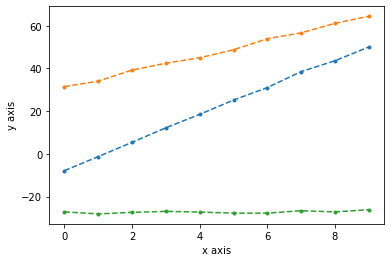

In [7]:
# We can check the dataset by plotting few random exampless:
plt.figure()
plt.plot(xarray,lines[np.random.randint(0,lines.shape[0]),:],'.--')
plt.plot(xarray,lines[np.random.randint(0,lines.shape[0]),:],'.--')
plt.plot(xarray,lines[np.random.randint(0,lines.shape[0]),:],'.--')
plt.xlabel('x axis'); plt.ylabel('y axis')

In [8]:
# We now include the samples into a PyTorch class Dataset
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, lines, values):
        'Initialization'
        self.lines = lines
        self.values = values

  def __len__(self):
        'Denotes the total number of samples'
        return self.values.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        x = values[index,:]
        y = lines[index,:]
        return x, y

# Data container:
training_set = Dataset(lines, values)
train_loader = torch.utils.data.DataLoader(training_set,batch_size=args.batch_size,shuffle=True)

In [9]:
# We normalize the data during training to achieve a faster convergence:
x_std = train_loader.dataset.lines.std((0,1))
y_std = train_loader.dataset.values.std((0))
print('x_std, y_std: ',x_std,y_std)

x_std, y_std:  42.3724 [ 5.793013 28.963675]


## Definition of the normalizing flow

In [10]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Flow layers:

# Here we use a Piecewise Rational Quadratic spline in a coupling transform (like in the paper)
# but simpler options are also available.
def PiecewiseRationalQuadraticCouplingTransform(iflow, input_size, hidden_size, context_size, num_blocks=1, activation=F.elu, num_bins=8):
    return transforms.PiecewiseRationalQuadraticCouplingTransform(
        mask=utils.create_alternating_binary_mask(input_size, even=(iflow % 2 == 0)),
        transform_net_create_fn=(lambda in_features, out_features: nets.ResidualNet(in_features=in_features, 
        out_features=out_features, hidden_features=hidden_size,context_features=context_size, num_blocks=num_blocks,activation=activation)),
        num_bins=num_bins, tails='linear', tail_bound=5, apply_unconditional_transform=False)

# Between each Coupling layer we have a layer that suffle the order of the variables
def create_linear_transform(param_dim):
    return transforms.CompositeTransform([
        transforms.RandomPermutation(features=param_dim),
        transforms.LULinear(param_dim, identity_init=True)])

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

num_layers = 5 # number of "sub-flows"
mhidden_features = 32 # neurons in each layer of the ResNet network that infers the spline parameters
base_dist = nflows.distributions.StandardNormal((2,)) # Multivariate Gaussian distribution

transformsi = []
for _ in range(num_layers):
    transformsi.append(create_linear_transform(param_dim=2))
    transformsi.append(PiecewiseRationalQuadraticCouplingTransform(_, 2, mhidden_features, context_size=10))
transformsi.append(create_linear_transform(param_dim=2))
transformflow = CompositeTransform(transformsi)

# The Flow class creates the flow model by joining the base distribution and the previously defined layers.
model = Flow(transformflow, base_dist)

In [11]:
# Size and network parameters
args.y_size = 2 # Number of parameters
args.x_size = xarray.shape[0] # Input size
pytorch_total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params to optimize:', pytorch_total_params_grad)

Total params to optimize: 18071


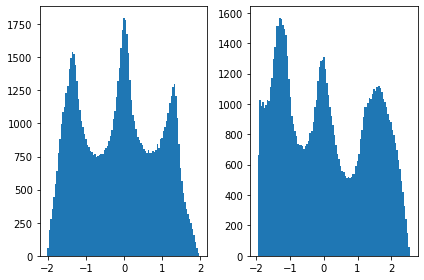

In [12]:
# Transformation before training:
zz = model.transform_to_noise(inputs=torch.from_numpy(values)/y_std, context=torch.from_numpy(lines)/x_std).detach().numpy()

# The latent space z is not Gaussian yet
plt.figure()
plt.subplot(121)
plt.hist(zz[:,0],bins=100);
plt.subplot(122)
plt.hist(zz[:,1],bins=100);
plt.tight_layout()

## Training of the normalizing flow

In [13]:
# Optimization of the normalizing flow

# We have to choose the optimization method and parameters to optimize
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

# Every loop takes a batch of data, calculates the logprob and change the 
# parameters of the flow:
train_loss_avg = []
time0 = time.time()

model.train()
for epoch in range(1, args.num_epochs + 1):
    train_loss = []
    for batch_idx, (params, data) in enumerate(train_loader):
        data = data.to(device)
        params = params.to(device)
        optimizer.zero_grad()

        x = torch.tensor(data[:,:].numpy(), dtype=torch.float32)/x_std
        y = torch.tensor(params[:,:].numpy(), dtype=torch.float32)/y_std

        optimizer.zero_grad()
        loss = -model.log_prob(inputs=y, context=x).mean()

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss_avg.append(np.mean(np.array(train_loss)))
    if epoch % args.log_interval ==0: print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss.item()))

# We can print the total training time:
print('Training: {0:2.2f} min'.format( (time.time()-time0)/60.) )

====> Epoch: 2 Average loss: -5.0879
====> Epoch: 4 Average loss: -6.1069
====> Epoch: 6 Average loss: -6.4681
====> Epoch: 8 Average loss: -6.4998
====> Epoch: 10 Average loss: -6.7458
====> Epoch: 12 Average loss: -6.8756
Training: 4.53 min


Text(0, 0.5, '-log prob')

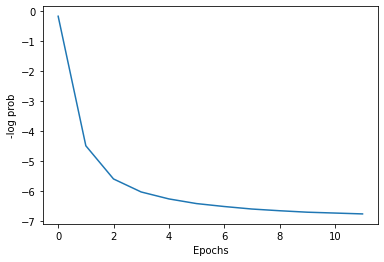

In [14]:
# The evolution of logprob with epochs
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('-log prob')

Latent z_0 (mu=0.3, std=1.0)
Latent z_1 (mu=-0.1, std=1.0)


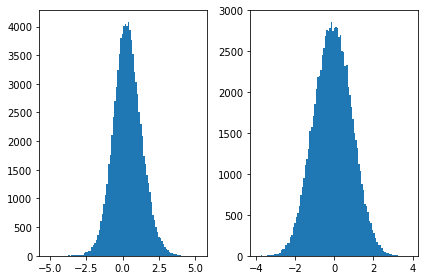

In [15]:
# Transformation after training
zz = model.transform_to_noise(inputs=torch.from_numpy(values)/y_std, context=torch.from_numpy(lines)/x_std).detach().numpy()

# Now the latent space has mean=0 and sigma=0
print('Latent z_0 (mu={0:2.1f}, std={1:2.1f})'.format(zz[:,0].mean(),zz[:,0].std()))
print('Latent z_1 (mu={0:2.1f}, std={1:2.1f})'.format(zz[:,1].mean(),zz[:,1].std()))

plt.figure()
plt.subplot(121)
plt.hist(zz[:,0],bins=100);
plt.subplot(122)
plt.hist(zz[:,1],bins=100);
plt.tight_layout()

## Evaluating an example

Sampling the posterior: 0.07199954986572266 s


Text(0, 0.5, 'y axis')

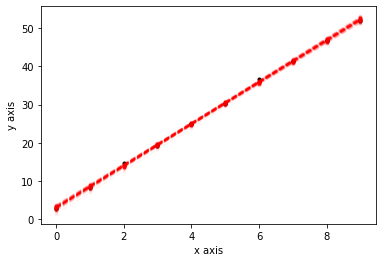

In [16]:
# Generate a test sample
testvalue = [5.5,3.0]
testobs = mymodel(xarray,testvalue[0],testvalue[1],noise)

# We can also choose the number of samples
nsamples = 5000

time0 = time.time()
samples_histo = model.sample(1,context=torch.tensor(testobs).repeat(nsamples,1)/x_std).data.cpu().numpy()
print('Sampling the posterior:',time.time()-time0,'s')

# Comparison between data and samples from the posterior
samples_histo = samples_histo[:,0,:]*y_std

plt.figure()
plt.plot(xarray,testobs,'k.')
for ii in range(100):
    plt.plot(xarray,xarray*samples_histo[ii,0] + samples_histo[ii,1],'r.--',alpha=0.05)
plt.xlabel('x axis'); plt.ylabel('y axis')

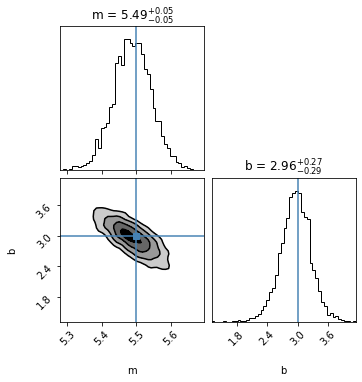

In [17]:
# And show a corner plot of the solution
figure = corner.corner(samples_histo,labels=['m','b'],truths=testvalue,show_titles=True,plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)

## Comparison with MCMC

In [18]:
# We need to define the likelihood and prior
# based on our previous example:

def log_likelihood(theta, x, y, yerr):
    m, b, = theta
    model = m * x + b
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -10.0 < m < 10.0 and -50.0 < b < 50.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [19]:
# We can now run an MCMC method to retrieve the posterior:
x = np.copy(xarray)
y = np.copy(testobs)
yerr = np.ones(y.shape[0],dtype=np.float32)*noise
nwalkers = 50
ndim = 2
pos_init = [+1.e+0*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos_init, 5000, progress=True);

100%|██████████| 5000/5000 [00:09<00:00, 507.05it/s]


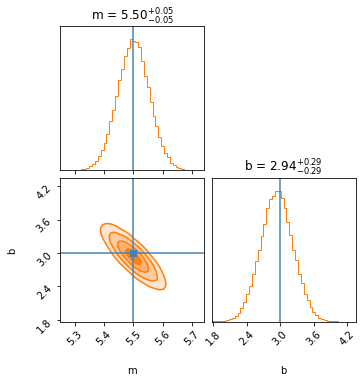

In [20]:
# And show a corner plot of the solution
samples_emcee = sampler.flatchain[10000:,:]
figure = corner.corner(samples_emcee,labels=['m','b'],truths=testvalue,show_titles=True,plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, color='C1')

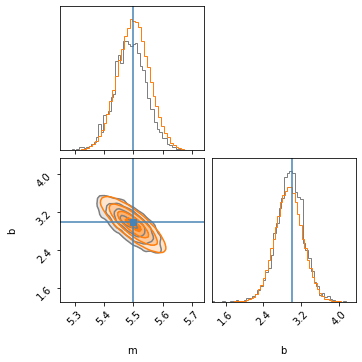

In [21]:
# Now we can compare the result of the normalizing flow with the one obtained with the MCMC

# Orange => MCMC, gray => NN
figure = corner.corner(samples_histo,labels=['m','b'], weights=np.ones(samples_histo.shape[0])*samples_emcee.shape[0]/samples_histo.shape[0], color='gray', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0)
_ = corner.corner(sampler.flatchain[10000:,:],labels=['m','b'],truths=testvalue, color='C1', plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0,fig=figure)